## 1. Setup

# 🔬 Test ImageDataGenerator (TensorFlow Keras)

Ce notebook teste `ImageDataGenerator` de Keras avec le dataset COVID-19 et compare avec notre `ImageAugmenter` custom.

## 📚 Documentation tf.keras.preprocessing.image

**Source:** https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image

### ⚠️ STATUT DEPRECATED
D'après la documentation officielle TensorFlow (dernière mise à jour: 2024-04-26):

**Classes DEPRECATED:**
- `ImageDataGenerator` - **DEPRECATED** ⚠️
- Iterators (DirectoryIterator, NumpyArrayIterator)

**Fonctions DEPRECATED:**
- `random_rotation()` - **DEPRECATED**
- `random_shear()` - **DEPRECATED**
- `random_shift()` - **DEPRECATED**
- `random_zoom()` - **DEPRECATED**

### ✅ Fonctions utilitaires toujours valides
- `load_img()` : Charge image → PIL.Image
- `img_to_array()` : PIL → numpy.ndarray
- `array_to_img()` : numpy → PIL
- `smart_resize()` : Redimensionnement intelligent (préserve aspect ratio)
- `apply_affine_transform()` : Transformations affines manuelles
- `apply_brightness_shift()` : Ajustement luminosité
- `random_brightness()` : Luminosité aléatoire

### 🚀 ALTERNATIVE MODERNE RECOMMANDÉE
**`tf.keras.utils.image_dataset_from_directory`**
- API moderne non-deprecated
- Utilise `tf.data.Dataset` (pipeline optimisé)
- Compatible avec TensorFlow 2.x+
- Meilleure performance et flexibilité

## 🎯 Objectifs de ce notebook
1. Tester `ImageDataGenerator` (legacy) avec notre dataset COVID-19
2. Comparer avec notre `ImageAugmenter` custom
3. Benchmark de performance
4. Démontrer `tf.data` API moderne (section 12)

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Vérifier version TensorFlow
print(f"TensorFlow version: {tf.__version__}")

# Configuration
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "COVID-19_Radiography_Dataset" / "COVID-19_Radiography_Dataset"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

print(f"Dataset path: {DATA_DIR}")
print(f"Dataset exists: {DATA_DIR.exists()}")

TensorFlow version: 2.20.0
Dataset path: /home/cepa/DST/projet_DS/DS_COVID_ORGA/data/raw/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset
Dataset exists: True


## 2. Explorer la structure du dataset

In [9]:
# Lister les classes
classes = [d.name for d in DATA_DIR.iterdir() if d.is_dir()]
print(f"Classes trouvées: {classes}\n")

# Compter les images par classe
for cls in classes:
    img_dir = DATA_DIR / cls / "images"
    if img_dir.exists():
        n_images = len(list(img_dir.glob("*.png")))
        print(f"  {cls:20s}: {n_images:5d} images")

Classes trouvées: ['Viral Pneumonia', 'Normal', 'Lung_Opacity', 'COVID']

  Viral Pneumonia     :  1345 images
  Normal              : 10192 images
  Lung_Opacity        :  6012 images
  COVID               :  3616 images


## 3. Créer ImageDataGenerator (sans augmentation)

In [10]:
# ImageDataGenerator basique (juste normalisation)
datagen_basic = ImageDataGenerator(
    rescale=1./255,  # Normalise les pixels [0, 255] → [0, 1]
    validation_split=0.2  # 20% pour validation
)

print("✅ ImageDataGenerator créé (rescale uniquement)")

✅ ImageDataGenerator créé (rescale uniquement)


## 4. Charger les données avec flow_from_directory

⚠️ **PROBLÈME** : Notre dataset a la structure `CLASS/images/*.png`, mais `flow_from_directory` attend `CLASS/*.png`.

**Solutions** :
1. Réorganiser temporairement le dataset
2. Utiliser des symlinks
3. Utiliser `flow()` avec nos propres loaders

In [11]:
# Vérifier la structure
print("Structure attendue par flow_from_directory:")
print("  data_dir/")
print("    ├── class1/")
print("    │   ├── img1.png")
print("    │   └── img2.png")
print("    └── class2/")
print("        ├── img3.png")
print("        └── img4.png")
print("\nStructure actuelle:")
print("  data_dir/")
print("    ├── class1/")
print("    │   ├── images/")
print("    │   │   ├── img1.png")
print("    │   │   └── img2.png")
print("    │   └── masks/")
print("\n⚠️ Incompatibilité détectée!")

Structure attendue par flow_from_directory:
  data_dir/
    ├── class1/
    │   ├── img1.png
    │   └── img2.png
    └── class2/
        ├── img3.png
        └── img4.png

Structure actuelle:
  data_dir/
    ├── class1/
    │   ├── images/
    │   │   ├── img1.png
    │   │   └── img2.png
    │   └── masks/

⚠️ Incompatibilité détectée!


## 5. Solution : Utiliser nos propres loaders avec flow()

In [12]:
# Charger les chemins avec notre fonction
import sys
sys.path.insert(0, str(PROJECT_ROOT))

from src.utils.data_utils import load_dataset_paths_and_labels
from PIL import Image

# Charger tous les chemins
image_paths, _, labels, labels_int = load_dataset_paths_and_labels(
    dataset_root_dir=DATA_DIR,
    class_names=["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"],
    n_images_per_class=500,  # Limiter pour test rapide
    load_masks=False,
    shuffle=True,
    random_seed=42,
    verbose=True
)

CHARGEMENT DES DONNÉES
  COVID               :  500 images [séquentiel]
  Normal              :  500 images [séquentiel]
  Lung_Opacity        :  500 images [séquentiel]
  Viral Pneumonia     :  500 images [séquentiel]

  🔀 Données mélangées (seed=42)

  Total: 2000 images
  Classes: 4
  Distribution: [500 500 500 500]
  🔀 Mélange activé (seed=42)


In [13]:
# Charger les images en mémoire
def load_images(paths, target_size=IMG_SIZE):
    """Charge les images et les redimensionne."""
    images = []
    for path in paths:
        img = Image.open(path).convert('RGB')  # Convert to RGB
        img = img.resize(target_size)
        images.append(np.array(img))
    return np.array(images)

print("Chargement des images en mémoire...")
X = load_images(image_paths, target_size=IMG_SIZE)
y = labels_int

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Pixel range: [{X.min()}, {X.max()}]")
print(f"Dtype: {X.dtype}")

Chargement des images en mémoire...

X shape: (2000, 256, 256, 3)
y shape: (2000,)
Pixel range: [0, 255]
Dtype: uint8


## 6. Créer ImageDataGenerator avec augmentations

In [14]:
datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # Rotation aléatoire ±20°
    width_shift_range=0.1,       # Shift horizontal ±10%
    height_shift_range=0.1,      # Shift vertical ±10%
    horizontal_flip=True,        # Flip horizontal aléatoire
    zoom_range=0.2,              # Zoom ±20%
    brightness_range=[0.8, 1.2], # Luminosité ±20%
    fill_mode='nearest',         # Mode de remplissage pour rotations
    validation_split=0.2
)

print("✅ ImageDataGenerator créé avec augmentations")
print("\nParamètres d'augmentation:")
print(f"  - Rotation: ±{datagen_augmented.rotation_range}°")
print(f"  - Shift: ±{datagen_augmented.width_shift_range*100}%")
print(f"  - Zoom: ±{datagen_augmented.zoom_range[1]*100 if isinstance(datagen_augmented.zoom_range, list) else datagen_augmented.zoom_range*100}%")
print(f"  - Horizontal flip: {datagen_augmented.horizontal_flip}")
print(f"  - Brightness: {datagen_augmented.brightness_range}")

✅ ImageDataGenerator créé avec augmentations

Paramètres d'augmentation:
  - Rotation: ±20°
  - Shift: ±10.0%
  - Zoom: ±120.0%
  - Horizontal flip: True
  - Brightness: [0.8, 1.2]


## 7. Tester l'augmentation sur quelques images

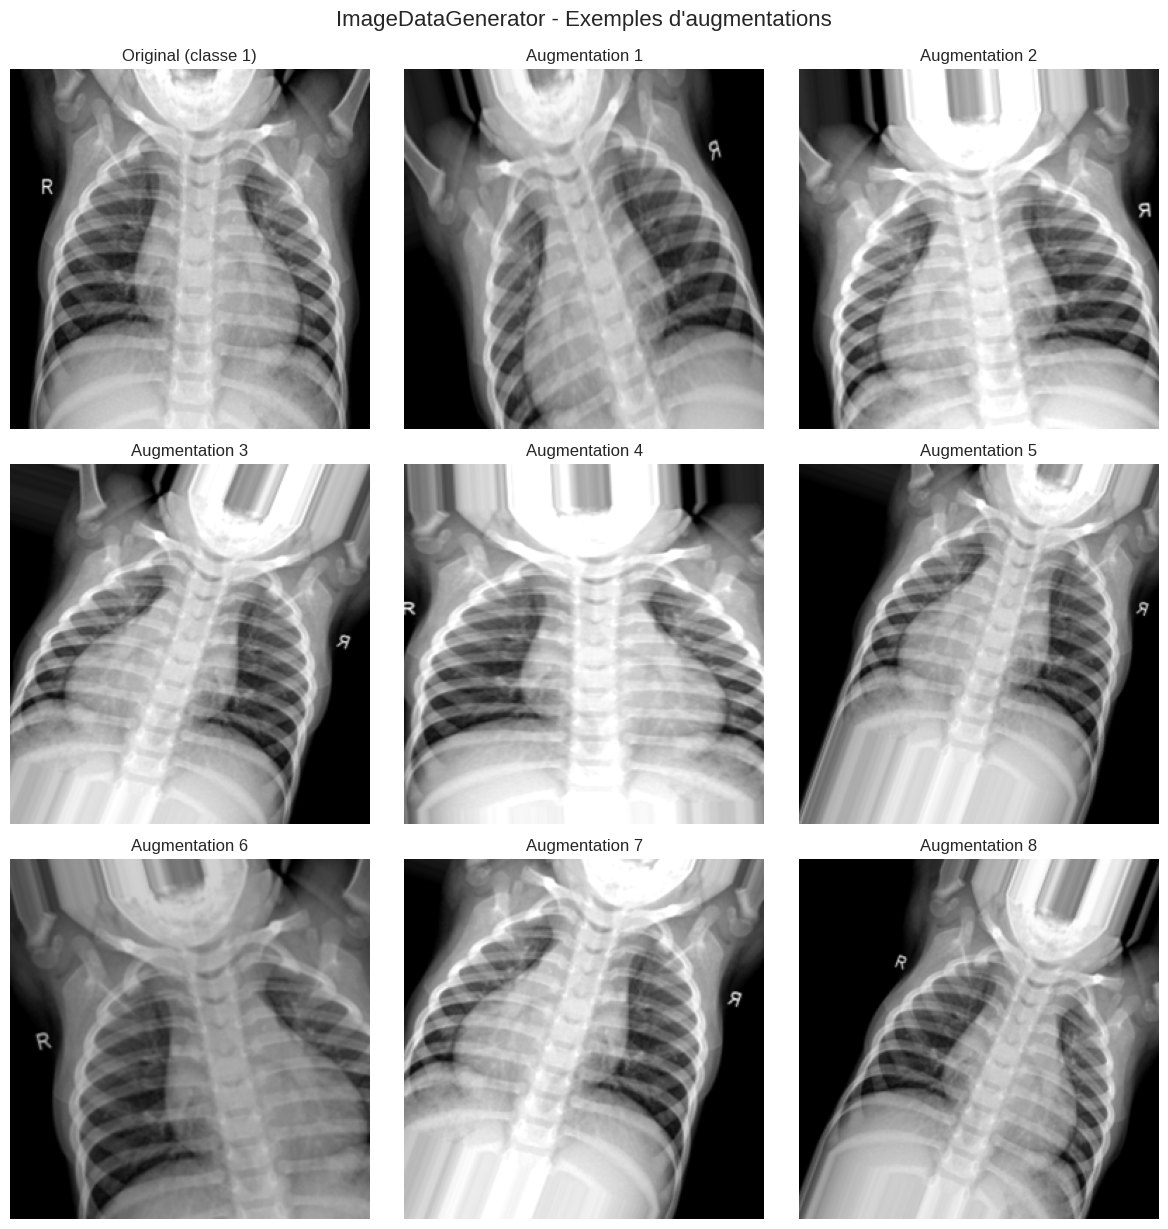

In [15]:
# Prendre une image d'exemple
sample_idx = 0
sample_image = X[sample_idx:sample_idx+1]  # Shape (1, H, W, C)
sample_label = y[sample_idx]

# Générer 9 versions augmentées
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Image originale
axes[0].imshow(sample_image[0].astype(np.uint8))
axes[0].set_title(f"Original (classe {sample_label})")
axes[0].axis('off')

# Générer et afficher 8 augmentations
gen = datagen_augmented.flow(sample_image, batch_size=1, shuffle=False)
for i in range(1, 9):
    augmented = next(gen)[0]
    axes[i].imshow(augmented)
    axes[i].set_title(f"Augmentation {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("ImageDataGenerator - Exemples d'augmentations", fontsize=16, y=1.02)
plt.show()

## 8. Comparer avec notre ImageAugmenter custom

In [16]:
from src.features.Pipelines.transformateurs.image_augmentation import ImageAugmenter

# Créer notre augmenter avec des paramètres similaires
custom_augmenter = ImageAugmenter(
    flip_horizontal=True,
    flip_vertical=False,
    rotation_range=20,
    brightness_range=(0.8, 1.2),
    noise_std=0.0,
    zoom_range=(0.8, 1.2),
    probability=1.0,  # 100% pour voir toutes les augmentations
    seed=42,
    verbose=True
)

print("✅ ImageAugmenter custom créé")

✅ ImageAugmenter custom créé


Augmentation: 100%|██████████| 1/1 [00:00<00:00, 26.45it/s]


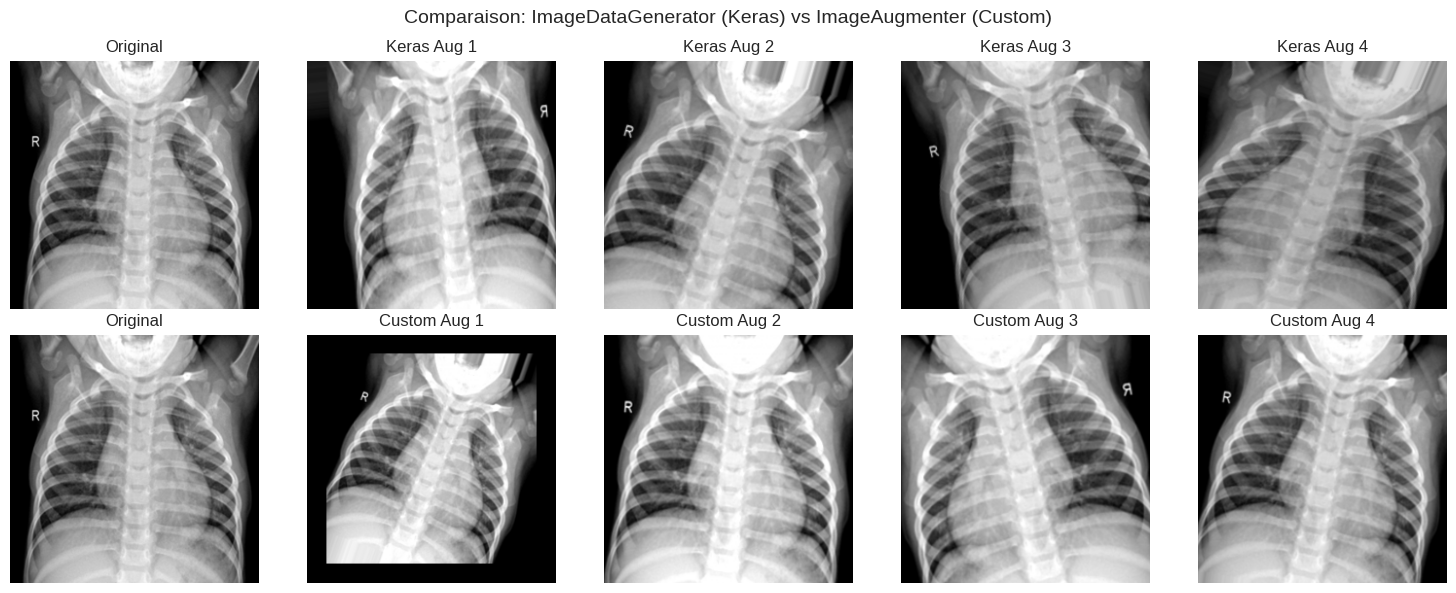

In [17]:
# Générer des augmentations avec notre custom augmenter
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Ligne 1: ImageDataGenerator (Keras)
axes[0, 0].imshow(sample_image[0].astype(np.uint8))
axes[0, 0].set_title("Original")
axes[0, 0].axis('off')

gen_keras = datagen_augmented.flow(sample_image, batch_size=1, shuffle=False, seed=42)
for i in range(1, 5):
    augmented = next(gen_keras)[0]
    axes[0, i].imshow(augmented)
    axes[0, i].set_title(f"Keras Aug {i}")
    axes[0, i].axis('off')

# Ligne 2: Notre ImageAugmenter
axes[1, 0].imshow(sample_image[0].astype(np.uint8))
axes[1, 0].set_title("Original")
axes[1, 0].axis('off')

for i in range(1, 5):
    custom_augmenter.seed = 42 + i  # Changer seed pour variété
    augmented = custom_augmenter.fit_transform(sample_image)
    axes[1, i].imshow(augmented[0].astype(np.uint8))
    axes[1, i].set_title(f"Custom Aug {i}")
    axes[1, i].axis('off')

plt.suptitle("Comparaison: ImageDataGenerator (Keras) vs ImageAugmenter (Custom)", fontsize=14)
plt.tight_layout()
plt.show()

## 9. Benchmark de performance

In [18]:
import time

# Préparer un batch de 32 images
batch_images = X[:32]

# Benchmark ImageDataGenerator
gen_keras = datagen_augmented.flow(batch_images, batch_size=32, shuffle=False)
start = time.time()
for _ in range(10):
    _ = next(gen_keras)
keras_time = time.time() - start

# Benchmark ImageAugmenter custom
custom_augmenter.probability = 1.0
start = time.time()
for _ in range(10):
    _ = custom_augmenter.transform(batch_images)
custom_time = time.time() - start

print("\n📊 BENCHMARK (10 itérations × 32 images):")
print(f"  ImageDataGenerator (Keras): {keras_time:.3f}s")
print(f"  ImageAugmenter (Custom):    {custom_time:.3f}s")
print(f"  Ratio: {custom_time/keras_time:.2f}x")

if custom_time < keras_time:
    print(f"\n✅ Notre augmenter est {keras_time/custom_time:.1f}x plus rapide!")
else:
    print(f"\n⚠️ Keras est {custom_time/keras_time:.1f}x plus rapide")

Augmentation: 100%|██████████| 32/32 [00:00<00:00, 36.45it/s]


📊 BENCHMARK (10 itérations × 32 images):
  ImageDataGenerator (Keras): 2.850s
  ImageAugmenter (Custom):    9.980s
  Ratio: 3.50x

⚠️ Keras est 3.5x plus rapide


## 10. Intégration avec model.fit()

In [ ]:
from tensorflow.keras import layers, models

# Créer un modèle simple pour démonstration
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modèle CNN créé")
model.summary()

In [ ]:
# Entraîner avec ImageDataGenerator
train_gen = datagen_augmented.flow(
    X, y,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

print("\n🚀 Entraînement avec ImageDataGenerator...")
history = model.fit(
    train_gen,
    steps_per_epoch=len(X) // BATCH_SIZE,
    epochs=2,  # Juste 2 epochs pour test
    verbose=1
)

print("\n✅ Entraînement terminé!")

## 11. Conclusion et recommandations

### 📊 Résumé de la documentation officielle TensorFlow

D'après https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image (dernière mise à jour: 2024-04-26):

**DEPRECATED depuis TensorFlow 2.16+:**
- ❌ `ImageDataGenerator` → Utiliser `tf.keras.utils.image_dataset_from_directory`
- ❌ `random_rotation()`, `random_shear()`, `random_shift()`, `random_zoom()`

**Fonctions toujours valides:**
- ✅ `load_img()`, `img_to_array()`, `array_to_img()`
- ✅ `smart_resize()`, `apply_brightness_shift()`

### 🎯 ImageDataGenerator (Keras) - LEGACY
**Avantages:**
- ✅ Intégration native avec TensorFlow/Keras
- ✅ API simple pour cas d'usage standards
- ✅ Génération à la volée (économie mémoire)
- ✅ flow_from_directory() pratique pour datasets organisés

**Inconvénients:**
- ❌ **API officiellement deprecated depuis TensorFlow 2.16**
- ❌ Moins flexible pour augmentations custom
- ❌ Incompatibilité avec notre structure de dossiers (CLASS/images/)
- ❌ Difficile à debugger/visualiser les augmentations
- ❌ Sera supprimée dans les futures versions de TensorFlow

### 🎯 ImageAugmenter (Custom)
**Avantages:**
- ✅ sklearn compatible (fit/transform)
- ✅ Contrôle total sur les augmentations
- ✅ Plus facile à intégrer dans nos pipelines
- ✅ Fonctionne avec notre structure de données
- ✅ Testable et modulaire
- ✅ Pas de risque de deprecation

**Inconvénients:**
- ❌ Nécessite de charger les données en mémoire
- ❌ Pas d'intégration directe avec model.fit()
- ❌ Maintenance custom (mais avec contrôle total)

### 💡 Recommandation finale

**Pour ce projet:**

1. **Pipelines sklearn / ML classique** → **Garder ImageAugmenter**
   - ✅ Compatible avec notre architecture
   - ✅ Pas de risque de deprecation
   - ✅ Contrôle total et testabilité

2. **Entraînement Deep Learning** → **Utiliser tf.data.Dataset** (voir section 12)
   - ✅ API moderne officielle TensorFlow 2.x+
   - ✅ Non-deprecated
   - ✅ Performance optimale avec prefetch/cache
   - ✅ `tf.keras.utils.image_dataset_from_directory` ou custom tf.data pipeline

3. **À ÉVITER** → **ImageDataGenerator**
   - ❌ Deprecated officiellement
   - ❌ Sera supprimé dans les prochaines versions
   - ❌ Migration inévitable vers tf.data

**Alternatives modernes:**
- `tf.keras.utils.image_dataset_from_directory` + `tf.data` API
- `tf.image.*` pour augmentations (random_flip, random_brightness, etc.)
- Layers Keras d'augmentation : `tf.keras.layers.RandomFlip`, `RandomRotation`, etc.

## 12. Bonus: tf.data.Dataset (API moderne NON-DEPRECATED)

**Source:** https://www.tensorflow.org/api_docs/python/tf/data/Dataset

Cette API est la **recommandation officielle TensorFlow 2.x+** pour remplacer ImageDataGenerator.

### 🌟 Avantages de tf.data
- ✅ **Non-deprecated** (API stable et maintenue)
- ✅ Pipeline optimisé : prefetch, cache, parallel processing
- ✅ Compatible avec TPU/GPU
- ✅ Augmentations via `tf.image.*` ou Keras Layers
- ✅ Meilleure performance que ImageDataGenerator

### 🔧 Deux approches possibles

**1. tf.keras.utils.image_dataset_from_directory** (Simple)
```python
dataset = tf.keras.utils.image_dataset_from_directory(
    'data/path',
    labels='inferred',  # Déduit depuis structure dossiers
    image_size=(256, 256),
    batch_size=32
)
```

**2. Custom tf.data.Dataset** (Flexible - ci-dessous)

In [ ]:
# Exemple avec tf.data (API moderne OFFICIELLE)
def augment_tf_data(image, label):
    """
    Fonction d'augmentation pour tf.data.
    
    Utilise les fonctions tf.image.* qui sont toujours maintenues.
    Alternative: Keras preprocessing layers (tf.keras.layers.RandomFlip, etc.)
    """
    # Normalisation
    image = tf.cast(image, tf.float32) / 255.0
    
    # Augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Note: tf.image.random_* sont NON-deprecated contrairement à
    # tf.keras.preprocessing.image.random_*
    
    return image, label

# Créer un dataset TensorFlow
print("Création du dataset tf.data...")
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=len(X), seed=42)
dataset = dataset.map(augment_tf_data, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimisation performance

print("✅ tf.data.Dataset créé avec augmentations")
print("\n📌 Cette API est la recommandation OFFICIELLE TensorFlow 2.x+")
print("   Documentation: https://www.tensorflow.org/api_docs/python/tf/data/Dataset")
print("\n🔑 Différences avec ImageDataGenerator:")
print("   - ✅ Non-deprecated (stable à long terme)")
print("   - ✅ Performance optimisée (prefetch, cache, parallel)")
print("   - ✅ Compatible TPU/GPU out-of-the-box")
print("   - ✅ Plus flexible pour pipelines custom")

# Tester le dataset
print("\n🧪 Test du dataset:")
for batch_x, batch_y in dataset.take(1):
    print(f"   Batch shape: {batch_x.shape}")
    print(f"   Labels shape: {batch_y.shape}")
    print(f"   Pixel range: [{batch_x.numpy().min():.3f}, {batch_x.numpy().max():.3f}]")

## 13. Alternative: Keras Preprocessing Layers (recommandé pour simplicité)

**Documentation:** https://www.tensorflow.org/api_docs/python/tf/keras/layers

TensorFlow propose des **layers d'augmentation** intégrables directement dans le modèle:
- `tf.keras.layers.RandomFlip`
- `tf.keras.layers.RandomRotation`
- `tf.keras.layers.RandomZoom`
- `tf.keras.layers.RandomContrast`
- `tf.keras.layers.RandomBrightness`

### 🌟 Avantages
- ✅ Non-deprecated
- ✅ Augmentation fait partie du modèle (portabilité)
- ✅ Exécuté sur GPU automatiquement
- ✅ Code plus simple et lisible

In [ ]:
# Exemple avec Keras Preprocessing Layers
from tensorflow.keras import layers, models

# Créer un modèle avec augmentation intégrée
model_with_augmentation = models.Sequential([
    # Couche d'augmentation (exécutées sur GPU!)
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # ±10% = ±36°
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    
    # Normalisation
    layers.Rescaling(1./255),
    
    # Architecture CNN
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

print("✅ Modèle avec augmentation intégrée créé")
print("\n🌟 Avantages des Keras Preprocessing Layers:")
print("   - ✅ Augmentation fait partie du modèle (portabilité)")
print("   - ✅ Exécuté sur GPU (pas de bottleneck CPU)")
print("   - ✅ Code plus simple et lisible")
print("   - ✅ Non-deprecated (API stable)")
print("\n💡 Recommandation: Utiliser cette approche pour nouveaux projets!")

model_with_augmentation.summary()